In [63]:
import chainer
from PIL import Image, ImageDraw, ImageFont, ImageOps
import csv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import easyocr
from manga_ocr import MangaOcr
from scipy.ndimage import rotate
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

/home/ec2-user/code/restor-ai-tion/data/full/200004148/images/200004148_00002_2.jpg


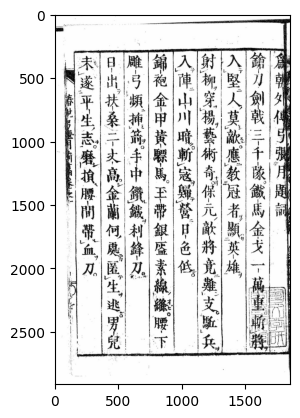

In [86]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_005.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200014685/images/200014685_00002_2.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/200004148/images/200004148_00002_2.jpg'
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/image2.png'
# inverted_filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/invertedimage2.png'
# image = Image.open(filename)
# inverted_image = ImageOps.invert(image)
# inverted_image.save(inverted_filename)
# filename = inverted_filename
print(filename)
image = Image.open(filename)
plt.imshow(image)
plt.show()

In [87]:
def predict(detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
            classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
            image_filename='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'):

    # unicode <-> unicode index mapping
    mapping = KuzushijiUnicodeMapping()
    
    # load trained detector
    detector = Res18UnetCenterNet()
    chainer.serializers.load_npz(detector_model, detector)
    
    # load trained classifier
    classifier = MobileNetV3(out_ch=len(mapping))
    chainer.serializers.load_npz(classifier_model, classifier)
    
    # load image
    image = Image.open(image_filename)
    
    # character detection
    bboxes, bbox_scores = detector.detect(image)
    
    # character classification
    unicode_indices, scores = classifier.classify(image, bboxes)
    unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]
    return unicodes, scores, bboxes, bbox_scores

In [88]:
unicodes, unicode_scores, bboxes, bbox_scores = predict(image_filename=filename)
print(unicodes)

['U+5165', 'U+5165', 'U+592B', 'U+4EBA', 'U+7D20', 'U+624B', 'U+82F1', 'U+5C71', 'U+7A7F', 'U+4E2D', 'U+55B6', 'U+91D1', 'U+5343', 'U+5DDD', 'U+9AD8', 'U+8840', 'U+5200', 'U+9EC4', 'U+6208', 'U+7389', 'U+67F3', 'U+6575', 'U+91D1', 'U+6697', 'U+51FA', 'U+5E2F', 'U+5947', 'U+9A43', 'U+5805', 'U+5FDC', 'U+6851', 'U+4F4E', 'U+5FD7', 'U+9663', 'U+7DDA', 'U+65AC', 'U+652F', 'U+4E00', 'U+7BAD', 'U+82B8', 'U+9326', 'U+621F', 'U+862D', 'U+888D', 'U+4F55', 'U+65E5', 'U+6276', 'U+5F13', 'U+5BC7', 'U+5E2F', 'U+9397', 'U+5200', 'U+8005', 'U+968A', 'U+51A0', 'U+751F', 'U+83AB', 'U+5143', 'U+8853', 'U+672A', 'U+FA68', 'U+9244', 'U+7532', 'U+533F', 'U+91D1', 'U+5263', 'U+78E8', 'U+96D5', 'U+6559', 'U+9244', 'U+8272', 'U+8170', 'U+6B74', 'U+947D', 'U+5E73', 'U+9042', 'U+640D', 'U+5C06', 'U+5C04', 'U+5200', 'U+633F', 'U+4FDD', 'U+9280', 'U+5229', 'U+751F', 'U+4E8C', 'U+983B', 'U+9593', 'U+9855', 'U+51E6', 'U+7E2B', 'U+99AC', 'U+694A', 'U+96C4', 'U+7ADF', 'U+65E5', 'U+9003', 'U+9C36', 'U+4E07', 'U+6575',

In [95]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 50, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'
true_color = 'rgb(0, 0, 255)'

def bbox_values(bbox):
    divisor = 1
    return int(bbox[0]/divisor), int(bbox[1]/divisor), int(bbox[2]/divisor), int(bbox[3]/divisor)

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    full_dataset='/home/ec2-user/code/restor-ai-tion/data/full',
                    same_image=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    true_img = Image.open(orig_filename)
    pred_draw = ImageDraw.Draw(pred_img)
    true_draw = ImageDraw.Draw(true_img)
    if limit == -1:
        limit = len(unicodes)
    print('limit', limit)

    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print('!!!', pred, label, uscore, x, y, w, h, bscore)

        
        pred_draw.text((x - 50, y - 10), label, fill=text_color, font = font)
        # pred_draw.rectangle([(x, y), (w, h)], outline='blue', width=3)


    x = os.path.basename(orig_filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookanme = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

        image_name = x.split('.')[0]
        csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
        print(csv_file)
        true_unicodes = []
        true_bboxes = []
        with open(csv_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Image'] == image_name:
                    uc = row['Unicode']
                    true_unicodes.append(chr(int(uc[2:], 16)))
                    true_bboxes.append([int(row['X']), int(row['Y']), int(row['Width']), int(row['Height'])])

        print(len(true_unicodes), len(unicodes))
        total = len(true_unicodes)

        if same_image:
            dimg = pred_draw
        else:
            dimg = true_draw
        for (uc, bbox) in zip(true_unicodes, true_bboxes):
            x, y, w, h = bbox_values(bbox)
            w = w + x
            h = h + y
            if verbose:
                print('>', pred, label, uscore, x, y, w, h, bscore)
    
            
            dimg.text((x + 100, y - 10), uc, fill=true_color, font = font)
            # dimg.rectangle([(x, y), (w, h)], outline='green', width=4)  
            found_char = False
            for (pred, pbbox) in zip(unicodes[:limit], bboxes[:limit]):
                # if abs(xpred - x) < 200.0 and abs(ypred - y) < 200.0 and cpred == char:
                xpred, ypred, width, height = bbox_values(pbbox)
                puc = chr(int(pred[2:], 16))
                if abs(xpred - x) < 200 and abs(ypred - y) < 200 and puc == uc:
                    found_char = True
                    break
            if found_char:
                num_correct += 1
            else:
                num_wrong += 1

        print('accuracy', total, (num_correct*1.0/total), (num_wrong*1.0)/total)

    if same_image or not true_image_available:
        plt.figure()
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_filename]
    else:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(true_img)
        plt.title('True')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        
        basename = os.path.basename(orig_filename)
        save_true_filename = os.path.join(save_folder, 'true_{}'.format(basename))
        true_img.save(save_true_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_true_filename, save_filename]

    return viz_filenames


limit 109
200004148_00002_2.jpg
/home/ec2-user/code/restor-ai-tion/data/full/200004148/200004148_coordinate.csv
120 109
accuracy 120 0.8583333333333333 0.14166666666666666


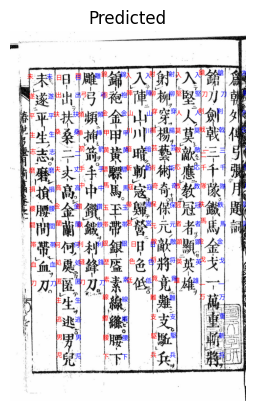

In [96]:
pred_filenames = visualize_preds(filename,
                                 unicodes, unicode_scores, bboxes, bbox_scores, 
                                 same_image=True,
                                 limit=-1, verbose=False)
pred_filename = pred_filenames[0]

In [208]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'い な を や ひ の 四 き 後 れ を ず に ふ ち ん は ま う か る て た 帰 れ 十 人 り 候 の 屋 つ 四 其 に 有 ん た り あ て は た つ き ま ゆ も る た し 五 ほ と く ね い 是 に は う し は と'

In [209]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [210]:
get_text(unicodes, bboxes, limit=10)

[('い', (831, 424, 891, 459)), ('な', (368, 758, 421, 816)), ('を', (1249, 880, 1307, 962)), ('や', (521, 726, 610, 805)), ('ひ', (902, 950, 961, 1030)), ('の', (1238, 829, 1318, 888)), ('四', (407, 358, 466, 411)), ('き', (1022, 326, 1084, 407)), ('後', (1249, 218, 1320, 309)), ('れ', (519, 921, 594, 1022))]


In [211]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

[[ 831  424  891  459]
 [ 368  758  421  816]
 [1249  880 1307  962]
 [ 521  726  610  805]
 [ 902  950  961 1030]
 [1238  829 1318  888]
 [ 407  358  466  411]
 [1022  326 1084  407]
 [1249  218 1320  309]
 [ 519  921  594 1022]]


In [212]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



[(831, 424, 59, 34), (368, 758, 52, 57), (1249, 880, 58, 81), (521, 726, 89, 79), (902, 950, 58, 79), (1238, 829, 80, 58), (407, 358, 59, 52), (1022, 326, 62, 81), (1249, 218, 71, 91), (519, 921, 75, 101)]
い な を や ひ の 四 き 後 れ を ず に ふ ち ん は ま う か る て た 帰 れ 十 人 り 候 の 屋 つ 四 其 に 有 ん た り あ て は た つ き ま ゆ も る た し 五 ほ と く ね い 是 に は う し は と


In [213]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

(array([[[ 749, 1079]],
 
        [[ 748, 1080]],
 
        [[ 744, 1080]],
 
        [[ 748, 1080]],
 
        [[ 749, 1079]],
 
        [[ 752, 1079]],
 
        [[ 753, 1080]],
 
        [[ 754, 1080]],
 
        [[ 755, 1081]],
 
        [[ 756, 1081]],
 
        [[ 760, 1085]],
 
        [[ 760, 1088]],
 
        [[ 758, 1090]],
 
        [[ 757, 1089]],
 
        [[ 756, 1089]],
 
        [[ 754, 1087]],
 
        [[ 754, 1084]],
 
        [[ 752, 1082]],
 
        [[ 746, 1082]],
 
        [[ 751, 1082]],
 
        [[ 752, 1083]],
 
        [[ 753, 1083]],
 
        [[ 754, 1084]],
 
        [[ 754, 1088]],
 
        [[ 755, 1089]],
 
        [[ 757, 1089]],
 
        [[ 758, 1090]],
 
        [[ 759, 1089]],
 
        [[ 760, 1089]],
 
        [[ 760, 1084]],
 
        [[ 758, 1082]],
 
        [[ 757, 1082]],
 
        [[ 756, 1081]],
 
        [[ 755, 1081]],
 
        [[ 754, 1080]],
 
        [[ 753, 1080]],
 
        [[ 752, 1079]]], dtype=int32),
 array([[[ 555, 1044]],
 

In [214]:
def ocr_image(tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds',
                    image_filename=filename):
    # new image attempt.
    tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
    pred_draw = ImageDraw.Draw(pred_image)
    limit = len(unicodes)
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_draw.text((x-20, y-10), label, fill=text_color, font = font)
    pred_image.save(tgt_filename)    
    
    ocr_img = cv2.imread(tgt_filename)
    plt.imshow(ocr_img)
    return tgt_filename

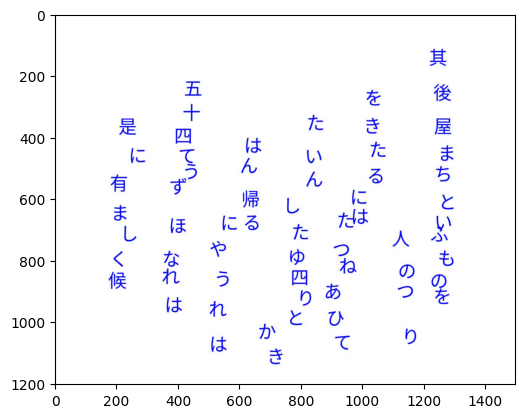

In [215]:
ocr_filename = ocr_image(image_filename=filename)

In [216]:
def easyocr_prediction(ocr_filename, detail=0):
    ## easyocr on modern japenese
    reader = easyocr.Reader(['ja'])
    result = reader.readtext(ocr_filename, detail = detail)
    return result

In [217]:
result = easyocr_prediction(pred_filename, detail=0)
' '.join(result)

'其1 飛 御 き 翼 樋 わ 艶 楓 、 ほ はる 智 鵜 羽 雷 も あ は ひ'

In [218]:
# manga-ocr
def mangaocr_prediction(tgt_filename):
    mocr = MangaOcr()
    text = mocr(tgt_filename)
    return text

In [219]:
text = mangaocr_prediction(pred_filename)
print(text)

2023-10-08 22:23:16.945 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-10-08 22:23:19.105 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-08 22:23:20.195 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


まあ、それは大丈夫ですね。私達は本当だと思っています。でも、そのために、この頃の不思議だったのですが、実はできません。


In [220]:
# new image (rotated) attempt.
def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

def rotate_image(image_filename, ocr_filename, tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(image_filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

    pred_draw = ImageDraw.Draw(pred_image)
    pred_rot_draw = ImageDraw.Draw(pred_rot_image)
    limit = len(unicodes)
    
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        xr, yr = rot((n, m), (m, n), (x,y))
        # print(x, y, xr, yr)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)

    pred_rot_image.save(tgt_rot_filename)    
    
    return tgt_rot_filename

def vizualize_ocrs(ocr_filename, ocr_rot_filename):
    ocr_image = cv2.imread(ocr_filename)
    ocr_rot_image = cv2.imread(ocr_rot_filename)
    
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    plt.imshow(ocr_image)
    plt.title('regular')
    
    plt.subplot(1,2,2)
    plt.imshow(ocr_rot_image)
    plt.title('rotated by 90')
    plt.show()

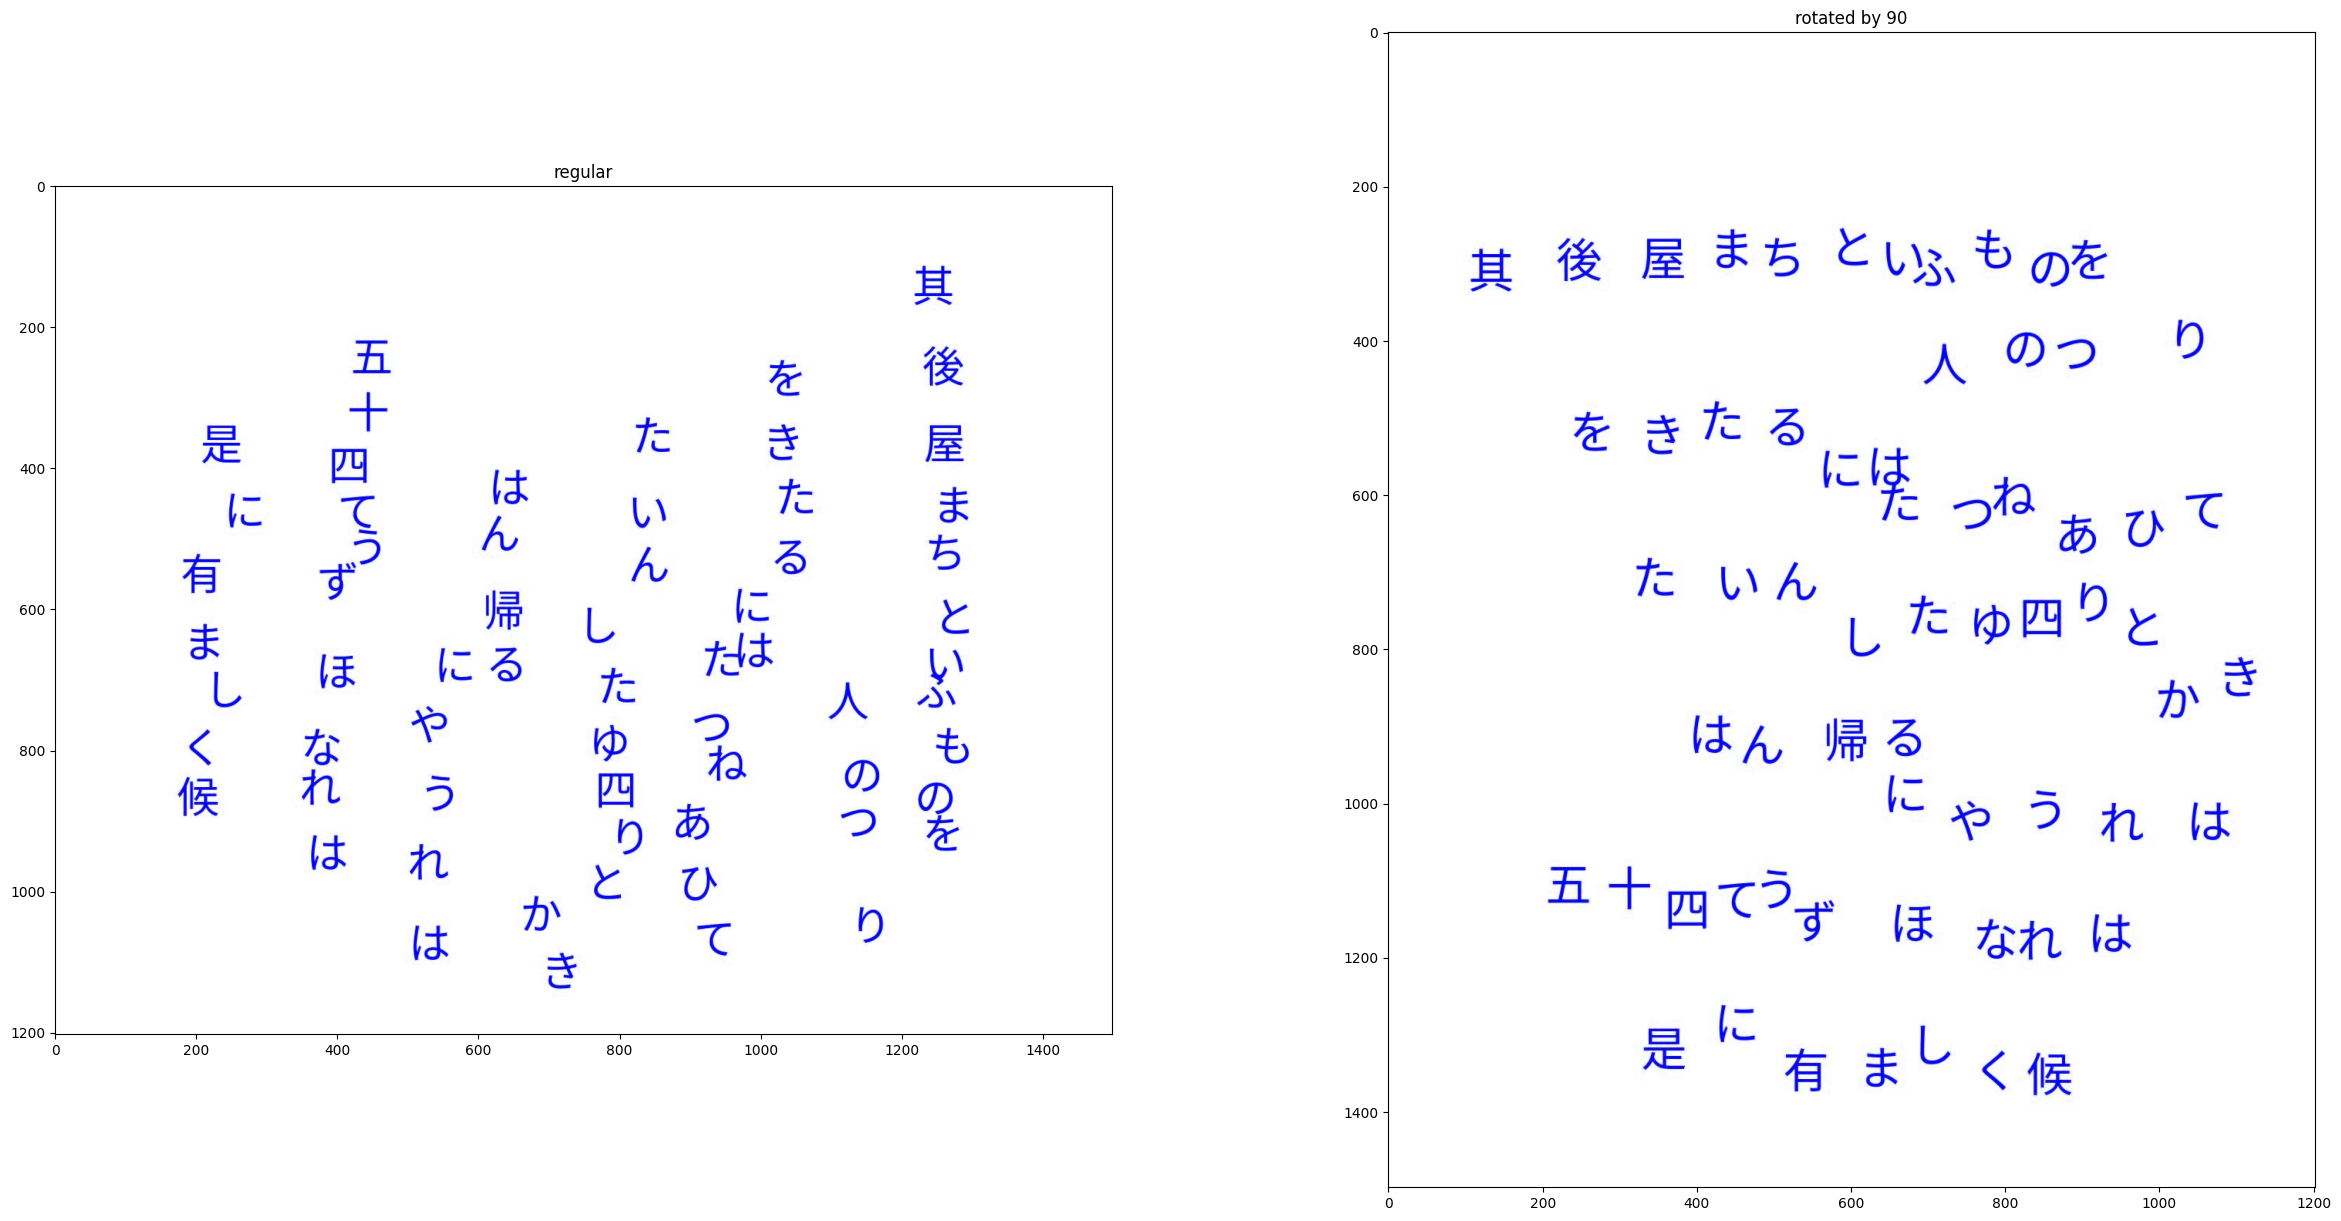

In [221]:
ocr_rot_filename = rotate_image(filename, ocr_filename)
vizualize_ocrs(ocr_filename, ocr_rot_filename)

In [222]:
result = easyocr_prediction(ocr_rot_filename, detail=1)
s = []
for x in result:
    s.append(x[1])
''.join(s)

'其 後屋 まち といふ ものをりをきたるにすた いんしたゆ四りとはん 帰るにゃうれ は五十四てうず  ほなれ は是に有 ましく候人 のつつねあひてかき'

In [223]:
text = mangaocr_prediction(ocr_rot_filename)
print(text)

2023-10-08 22:23:25.805 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-10-08 22:23:28.286 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-08 22:23:29.288 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


東海岸までというのは、本当なる、人のつりをきたいに思ったので、たいん。したけどと、世々帰ることが、帰国にやろうかは五回です。ほないは昼に有ましく。
